In [1]:
%matplotlib inline


# Solving Atari Breakout with DQN


<img src="file://_static/img/tutorials/blackjack_AE_loop.jpg" width="650" alt="agent-environment-diagram" class="only-light">
<img src="file://_static/img/tutorials/blackjack_AE_loop_dark.png" width="650" alt="agent-environment-diagram" class="only-dark">

In this tutorial, we’ll explore and solve the Atari *Breakout-v5*
environment.

**Breakout** is one of the most popular Atari games, with similar dynamics to pong. In Breakout, the
player controls a paddle that can move horizontally. The goal is to use the paddle to bounce a ball
against a wall of bricks, destroying the bricks in the process. 
Full documentation can be found at https://gymnasium.farama.org/environments/atari/breakout

**Objective**: To win, the player can destroy the two walls using five balls. Or, a player can 
win by scoring the maximum number of points, 864.

**Actions**: Agents can pick between two actions:
 - no-op (0): the player does not move
 - fire (1): the player fires a ball
 - right (2): the paddle moves right
 - left (3): the paddle moves left

**Approach**: To solve this environment by yourself, you can pick your
favorite discrete RL algorithm. The presented solution uses *DQN*
(a model-free RL algorithm).




## Imports and Environment Setup




In [2]:
# Author: Matthew Trang
# License: MIT License

from __future__ import annotations
from typing import Any, Callable, Dict, List, Optional, Tuple, Union

from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Patch
from tqdm import tqdm

import gymnasium as gym

import copy
import math
import os
import time
import random
import re
import warnings
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from itertools import count


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision

from IPython import display
from skimage.color import rgb2grey
from skimage.transform import rescale
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm
from collections import deque, namedtuple


# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()


plt.style.use('seaborn')
warnings.filterwarnings('ignore')

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Let's start by creating the breakout environment.
# Note: We are going to follow the rules from Sutton & Barto.

env = gym.make("ALE/Breakout-v5")

A.L.E: Arcade Learning Environment (version 0.8.0+919230b)
[Powered by Stella]


## Observing the environment

First of all, we call ``env.reset()`` to reset and start an episode. This function
resets the environment to a starting position and returns an initial
``observation``, which will be used by the agent later. We usually also set ``done = False``. This
variable will be used later to check if a game is terminated (i.e., the player wins or loses).

(In Gymnasium, an additional change is the ``truncated`` variable. This variable is set to ``True``
when the episode is terminated because the maximum number of steps is reached.)




In [3]:
# reset the environment to get the first observation
done = False
observation, info = env.reset()
print(observation.shape)
print(info)

# observation = ndarray(210, 160, 3)

(210, 160, 3)
{'lives': 5, 'episode_frame_number': 0, 'frame_number': 0}


Note that our observation is a 3-tuple consisting of 3 values, which represents the dimensions of the
RGB image displayed on the screen. The first value is the red channel, the second is the green channel,
and the third is the blue channel. The space is a ``Box`` space, which is a generalization of the
``Discrete`` space. It allows a discrete set of:
``Box(0, 255, (210, 160, 3), np.uint8)``.



## Executing an action

After receiving our first observation, we can now take an action to step the environment. We use the
``env.step(action)`` function to do this. 
The output of the function returns
five useful variables to us. These are:

-  ``next_state``: This is the observation that the agent will receive
   after taking the action.
-  ``reward``: This is the reward that the agent will receive after
   taking the action.
-  ``terminated``: This is a boolean variable that indicates whether or
   not the environment has terminated.
-  ``truncated``: This is a boolean variable that also indicates whether
   the episode ended by early truncation, i.e., a time limit is reached.
-  ``info``: This is a dictionary that might contain additional
   information about the environment.

The ``next_state``, ``reward``,  ``terminated`` and ``truncated`` variables are
self-explanatory, but the ``info`` variable requires some additional
explanation. This variable contains a dictionary that might have some
extra information about the environment. The info contained in this dictionary can vary widely from 
environment to environment. In the Atari environments the
info dictionary has a ``lives`` key that tells us how many lives the
agent has left. If the agent has 0 lives, then the episode is over.
In the ``Breakout-v5`` environment, the dictionary also contains an ``episode_frame_number``
and ``frame_number`` key. The ``episode_frame_number`` key tells us how many frames have passed
since the start of the episode. The ``frame_number`` key tells us how many frames have passed
since the start of the environment. The difference between these two is that the ``episode_frame_number``
is reset to 0 at the start of each episode, while the ``frame_number`` is not. This means that the
``frame_number`` will always be greater than or equal to the ``episode_frame_number``.





In [4]:
# sample a random action from all valid actions
action = env.action_space.sample()
print(action)
# action=1

# execute the action in our environment and receive infos from the environment
observation, reward, terminated, truncated, info = env.step(action)
print(observation.shape)
print(reward)
print(terminated)
print(truncated)
print(info)

# observation = ndarray(210, 160, 3)
# reward=0.0
# terminated=False
# truncated=False
# info={'lives': 5, 'episode_frame_number': 4, 'frame_number': 4}

2
(210, 160, 3)
0.0
False
False
{'lives': 5, 'episode_frame_number': 4, 'frame_number': 4}


Once ``terminated = True`` or ``truncated=True``, we should stop the
current episode and begin a new one with ``env.reset()``. If you
continue executing actions without resetting the environment, it still
responds but the output won’t be useful for training (it might even be
harmful if the agent learns on invalid data).




## Building an agent

We will now build an agent that will play the game for us. We will use a DQN agent, which is a model-free
RL algorithm. The DQN agent is a neural network that takes the current state as input and outputs
the Q-values for each action. The agent then picks the action with the highest Q-value and executes it.
The agent is trained by playing the game and updating the Q-values after each action. The Q-values are
updated using the Bellman equation. 

The DQN agent was first introduced in the paper [Playing Atari with Deep Reinforcement Learning](https://arxiv.org/abs/1312.5602) by Mnih et al. (2013).


We begin by building the buffer for the agent's experience replay. The buffer is a list of tuples that 
represent the agent's experience. Each tuple contains the following information: 
``(state, action, reward, next_state, terminated, truncated)``. The buffer is used to store the agent's experience
for the RL algorithm. The agent will sample from the buffer to train the neural network.

In [5]:
Transition = namedtuple('Transition', ['state', 'action', 'reward', 'next_state', 'terminated', 'truncated'])


class ReplayMemory():
    """
    Replay Memory that stores the last size=capacity transitions 

    Data is stored in the format: [state, action, reward, next_state, terminated, truncated]
    """
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size) -> List[Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]]:
        """Sample a batch of transitions"""
        return random.sample(self.memory, batch_size)

    def __len__(self) -> int:
        return len(self.memory)

Now, we initialize the DQN network. The DQN network is a neural network that takes the current state as input and outputs
the Q-values for each action.

The network layers consists of three sequential convolutional layers, followed by 2 fully connected layers.
The output of the layers is a vector of the same size as the number of actions, which for Breakout is 4.

In [20]:

class DQN(nn.Module):
    """
    Deep Q-Network

    """
    def __init__(self, env):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(4, 32, 8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(2304, 512),
            nn.ReLU(),
            nn.Linear(512, env.action_space.n),
        )

    def forward(self, x):
        return self.network(x)
    # def __init__(self, n_observations, n_actions):
    #     super(DQN, self).__init__()
    #     # Layers
    #     self.conv1 = nn.Conv2d(
    #         in_channels=n_observations,
    #         out_channels=16,
    #         kernel_size=8,
    #         stride=4,
    #         padding=2
    #         )
    #     self.conv2 = nn.Conv2d(
    #         in_channels=16,
    #         out_channels=32,
    #         kernel_size=4,
    #         stride=2,
    #         padding=1
    #         )
    #     self.linear1 = nn.Linear(3200, 256) 
    #     self.linear2 = nn.Linear(256, n_actions)

    # # Called with either one element to determine next action, or a batch
    # # during optimization. Returns tensor([[left0exp,right0exp]...]).
    # def forward(self, x) -> torch.Tensor:
    #     x = F.relu(self.conv1(x))
    #     x = F.relu(self.conv2(x))
    #     x = x.view(x.size(0), -1) # flatten
    #     x = F.relu(self.linear1(x))
    #     return self.linear2(x)


Now, with the DQN network which will form the brains of the agent, we can build the agent itself.
The agent is a class that contains the DQN network and the experience replay buffer. 

For Atari, a number of preprocessing steps are required to make the game easier to learn. For example,
frame stacking of 4 frames is used to give the agent a sense of motion. The frames are also resized to
84x84 pixels and converted to grayscale. The frames are also normalized to values between 0 and 1.

In [21]:

# Adapted from https://github.com/davidreiman/pytorch-atari-dqn/blob/master/dqn.ipynb
class DQNAgent():
    def __init__(self, env, memory_size, lr, gamma, start_eps, end_eps, anneal_time, batch_size, save_path):
        self.env = env
        self.frame_stack = 4 
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Initialize the q_network and target_network
        self.q_network = DQN(env).to(self.device)
        self.target_network = DQN(env).to(self.device)
        self.target_network.load_state_dict(self.q_network.state_dict())

        # Initialize replay buffer
        self.memory_size = memory_size
        self.memory = ReplayMemory(memory_size)

        # Initialize optimizer and loss function 
        self.loss = nn.SmoothL1Loss()
        self.optimizer = torch.optim.Adam(self.q_network.parameters(), lr=lr)

        # Initialize a repo to save checkpoints
        self.save_path = save_path
        if not os.path.isdir(save_path):
            os.makedirs(save_path)

        # Initialize run parameters
        self.batch_size = batch_size
        self.gamma = torch.tensor([gamma], device=self.device)
        self.tau = 1 # target network update rate
        self.start_eps = start_eps
        self.end_eps = end_eps
        self.anneal_time = anneal_time
        self.anneal_rate = (self.end_eps - self.start_eps) / self.anneal_time


        # additional hyperparameters
        self.learning_starts = int(1e4)
        self.update_interval = 4
        self.clone_interval = int(1e4)
        self.save_interval = int(1e5)

        self.start_time = time.time()

    def remember(self, batch_size) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor,torch.Tensor, torch.Tensor]:
        transitions = self.memory.sample(batch_size)
        batch = Transition(*zip(*transitions))
        #state, action, reward, next_state, terminated, truncated = transitions
        state, action, reward, next_state, terminated, truncated  = map(torch.cat, [*batch])
        return state, action, reward, next_state, terminated, truncated
    
    def act(self, state):
        q_values = self.q_network(state).detach()
        action = torch.argmax(q_values)
        return action.item()
    
    def preprocess(self, state):
        state = rgb2grey(state[35:195, :, :])
        state = rescale(state, scale=0.5)
        state = state[np.newaxis, np.newaxis, :, :] # batch, frame, height, width
        return torch.tensor(state, device=self.device, dtype=torch.float)
    
    def linear_schedule(self, t):
        return max(self.anneal_rate*t + self.start_eps, self.end_eps)
    
    def save(self, t):
        save_path = os.path.join(self.save_path, 'model-{}'.format(t))
        torch.save(self.q_network.state_dict(), save_path)
    
    def load(self):
        ckpts = [file for file in os.listdir(self.save_path) if 'model' in file]
        steps = [int(re.search('\d+', file).group(0)) for file in ckpts]
        
        latest_ckpt = ckpts[np.argmax(steps)]
        self.t = np.max(steps)
        
        print("Loading checkpoint: {}".format(latest_ckpt))
        
        self.q_network.load_state_dict(torch.load(os.path.join(self.save_path, latest_ckpt)))
        
    def update(self, batch_size):
        self.q_network.zero_grad()

        state, action, reward, next_state, terminated, truncated = self.remember(batch_size)
        q = self.q_network(state).gather(1, action.view(batch_size, 1))
        qmax = self.target_network(next_state).max(dim=1)[0]
        
        nonterminal_target = reward + self.gamma*qmax
        terminal_target = reward

        #Note: truncated and terminated could be interpreted differently, as a truncated episode is not necessarily terminated due to the fault of the agent

        terminated = terminated & truncated

        target = terminated.float()*terminal_target + (~terminated).float()*nonterminal_target
    
        loss = self.loss(q.view(-1), target)
        loss.backward()
        self.optimizer.step()

    def learn(self, episodes, load=False, plot=False, render=False, verbose=False):
        """
        Trains the agent

        Args:
            episodes (_type_): number of episodes to train for
            load (bool, optional): Whether or not to load a previously trained agent from a checkpoint. Defaults to False.
            plot (bool, optional): Whether or not to plot results. Defaults to False.
            render (bool, optional): Whether or not to render the environment. Defaults to False.
            verbose (bool, optional): Whether or not to print verbose output. Defaults to False.

        Returns:
            _type_: _description_
        """
    
        self.t = 0
        metadata = dict(episode=[], reward=[])
        
        if load:
            self.load()
        try:
            progress_bar = tqdm(range(episodes), unit='episode')
            i = 0
            for episode in progress_bar:

                obs, info = env.reset()
                obs = self.preprocess(obs) # convert raw rgb to formatted greyscale
                
                done = False
                total_reward = 0

                while not done:
                    if render:
                        env.render()

                    while obs.size()[1] < self.frame_stack:
                        action = 1 # Fire

                        new_frame, reward, terminated, truncated, info = env.step(action)
                        done = terminated or truncated
                        new_frame = self.preprocess(new_frame)

                        obs = torch.cat([obs, new_frame], 1) # stack the frames

                    # Calculate our action 
                    if np.random.uniform() < self.linear_schedule(self.t-self.learning_starts):
                        action = np.random.choice(self.env.action_space.n)
                    else:
                        action = self.act(obs)

                    new_frame, reward, terminated, truncated, info = env.step(action)
                    done = terminated or truncated
                    new_frame = self.preprocess(new_frame)

                    new_obs = torch.cat([obs, new_frame], 1)
                    new_obs = new_obs[:, 1:, :, :] # remove the oldest frame
                    
                    reward = torch.tensor([reward], device=self.device, dtype=torch.float)
                    action = torch.tensor([action], device=self.device, dtype=torch.long)
                    terminated = torch.tensor([terminated], device=self.device, dtype=torch.uint8)
                    truncated = torch.tensor([truncated], device=self.device, dtype=torch.uint8)
                    
                    self.memory.push(obs, action, reward, new_obs, terminated, truncated)

                    obs = new_obs
                    total_reward += reward
                    self.t += 1
                    i += 1
                    
                    if self.t > self.learning_starts and i > self.batch_size:

                        if self.t % self.update_interval == 0:
                            self.update(self.batch_size)

                        if self.t % self.clone_interval == 0:
                            for target_network_param, q_network_param in zip(self.target_network.parameters(), self.q_network.parameters()):
                                target_network_param.data.copy_(
                                    self.tau * q_network_param.data + (1.0 - self.tau) * target_network_param.data
                                )

                        if self.t % self.save_interval == 0:
                            self.save(self.t)

                    if self.t % 1000 == 0:
                        progress_bar.set_description("t = {}".format(self.t))

                metadata['episode'].append(episode)
                metadata['reward'].append(total_reward)

                if episode % 100 == 0 and episode != 0:
                    avg_return = torch.mean(torch.cat(metadata['reward'][-100:]))
                    print("Average return (last 100 episodes): {:.2f}".format(avg_return))

                if plot:
                    plt.scatter(metadata['episode'], torch.cat(metadata['reward']).cpu())
                    plt.xlim(0, episode)
                    plt.xlabel("Episode")
                    plt.ylabel("Return")
                    display.clear_output(wait=True)
                    display.display(plt.gcf())
            
            self.env.close()
            return metadata

        except KeyboardInterrupt:
            print("Saving model before quitting...")
            self.save(self.t)
            
            self.env.close()
            return metadata

    def play(self, episodes, load=False, plot=False, render=False, verbose=False):
        """
        Plays the agent for a given number of episodes

        Args:
            episodes (_type_): number of episodes to test for
            load (bool, optional): Whether or not to load a previously trained agent from a checkpoint. Defaults to False.
            plot (bool, optional): Whether or not to plot results. Defaults to False.
            render (bool, optional): Whether or not to render the environment. Defaults to False.
            verbose (bool, optional): Whether or not to print verbose output. Defaults to False.

        Returns:
            _type_: _description_
        """
    
        self.t = 0
        metadata = dict(episode=[], reward=[])
        if load:
            self.load()
        try:
            progress_bar = tqdm(range(episodes), unit='episode')
            i = 0
            for episode in progress_bar:

                obs, info = env.reset()
                obs = self.preprocess(obs) # convert raw rgb to formatted greyscale
                
                done = False
                total_reward = 0

                while not done:
                    if render:
                        env.render()

                    while obs.size()[1] < self.frame_stack:
                        action = 1 # Fire

                        new_frame, reward, terminated, truncated, info = env.step(action)
                        done = terminated or truncated
                        new_frame = self.preprocess(new_frame)

                        obs = torch.cat([obs, new_frame], 1) # stack the frames

                    action = self.act(obs)

                    new_frame, reward, terminated, truncated, info = env.step(action)
                    done = terminated or truncated
                    new_frame = self.preprocess(new_frame)

                    new_obs = torch.cat([obs, new_frame], 1)
                    new_obs = new_obs[:, 1:, :, :] # remove the oldest frame
                    
                    reward = torch.tensor([reward], device=self.device, dtype=torch.float)

                    obs = new_obs
                    total_reward += reward
                    self.t += 1
                    i += 1
                    

                metadata['episode'].append(episode)
                metadata['reward'].append(total_reward)

                if episode % 100 == 0 and episode != 0:
                    avg_return = torch.mean(torch.cat(metadata['reward'][-100:]))
                    print("Average return (last 100 episodes): {:.2f}".format(avg_return))

                if plot:
                    plt.scatter(metadata['episode'], torch.cat(metadata['reward']).cpu())
                    plt.xlim(0, episode)
                    plt.xlabel("Episode")
                    plt.ylabel("Return")
                    display.clear_output(wait=True)
                    display.display(plt.gcf())
            
            self.env.close()
            return metadata

        except KeyboardInterrupt:
            self.env.close()
            return metadata

To train the agent, we will let the agent play one episode (one complete
game is called an episode) at a time and then update it’s Q-values after
each episode. The agent will have to experience a lot of episodes to
explore the environment sufficiently.

Now we should be ready to build the training loop.




In [22]:
# hyperparameters
# learning_rate = 0.01
# n_episodes = 100_000
# start_epsilon = 1.0
# epsilon_decay = 1000
# final_epsilon = 0.1
# tau = 0.001  # target network update rate


# Hyperparameters

batch_size = 16
episodes = int(1e5)
memory_size = int(1e4)
epsilon_i = 1.0
epsilon_f = 0.1
anneal_time = int(1e6)
burn_in = int(5e4)
gamma = 0.99
learning_rate = 2.5e-4


#def __init__(self, n_observations, n_actions, batch_size=128, gamma=0.999, eps_start=0.9, eps_end=0.05, eps_decay=200, learning_rate=0.001, tau=0.001):
agent = DQNAgent(env=env, memory_size=memory_size, lr=learning_rate, gamma=gamma, start_eps=epsilon_i, end_eps=epsilon_f, anneal_time=anneal_time, batch_size=batch_size, save_path='dqn-model-v1')


Great, let’s train!

Info: The current hyperparameters are set to quickly train a decent agent.
If you want to converge to the optimal policy, try increasing
the n_episodes by 10x and lower the learning_rate (e.g. to 0.001).




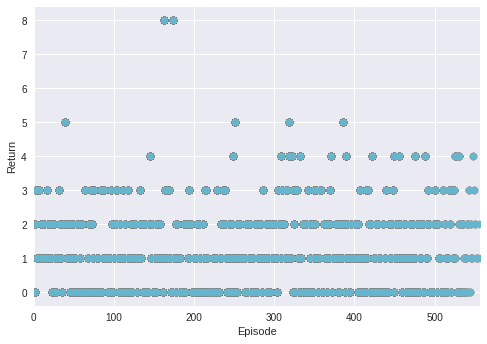

AttributeError: 'str' object has no attribute 'state_dict'

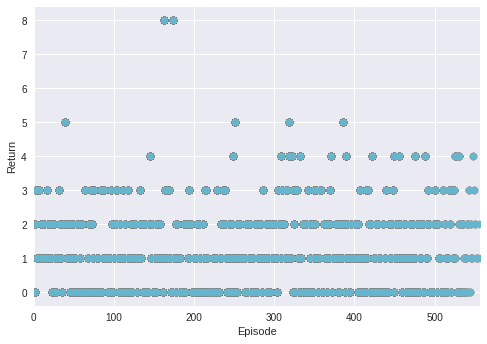

In [23]:
metadata = agent.learn(episodes, load=False, plot=True, render=False, verbose=False)

In [ ]:

test_metadata = agent.play(1, load=True, plot=True, render=True, verbose=False)

## Visualizing the training




AttributeError: 'AtariEnv' object has no attribute 'return_queue'

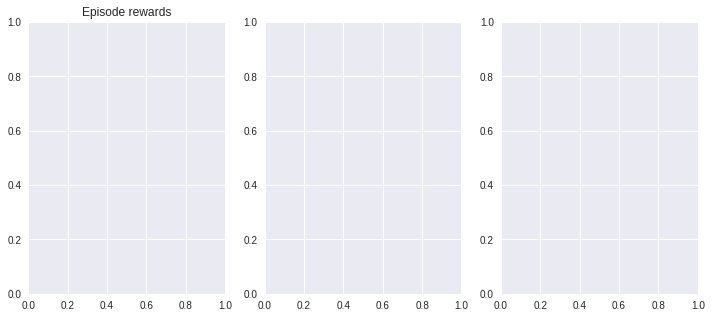

In [ ]:
rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
axs[0].set_title("Episode rewards")
reward_moving_average = (
    np.convolve(
        np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[1].set_title("Episode lengths")
length_moving_average = (
    np.convolve(
        np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same"
    )
    / rolling_length
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
axs[2].set_title("Training Error")
training_error_moving_average = (
    np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same")
    / rolling_length
)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
plt.tight_layout()
plt.show()

<img src="file://_static/img/tutorials/blackjack_training_plots.png">




## Visualising the policy



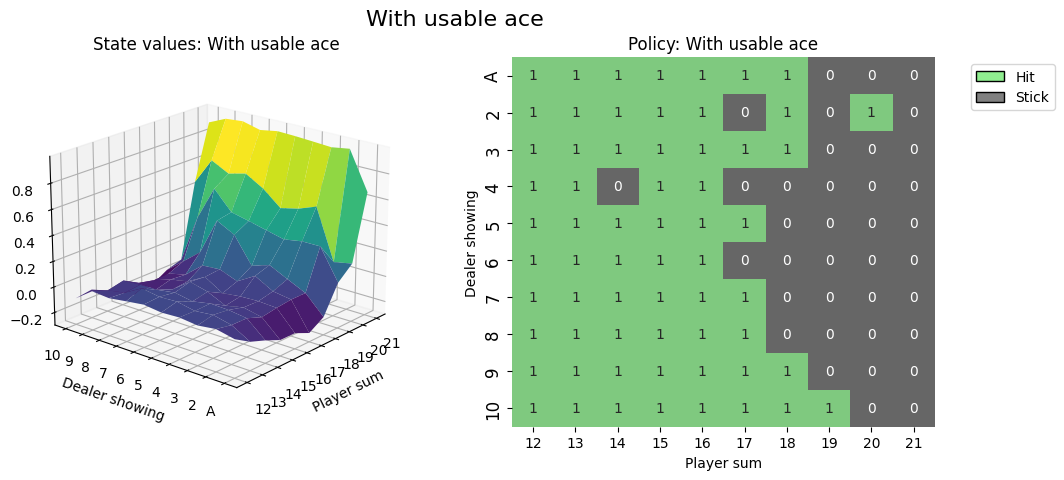

In [ ]:
def create_grids(agent, usable_ace=False):
    """Create value and policy grid given an agent."""
    # convert our state-action values to state values
    # and build a policy dictionary that maps observations to actions
    state_value = defaultdict(float)
    policy = defaultdict(int)
    for obs, action_values in agent.q_values.items():
        state_value[obs] = float(np.max(action_values))
        policy[obs] = int(np.argmax(action_values))

    player_count, dealer_count = np.meshgrid(
        # players count, dealers face-up card
        np.arange(12, 22),
        np.arange(1, 11),
    )

    # create the value grid for plotting
    value = np.apply_along_axis(
        lambda obs: state_value[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    value_grid = player_count, dealer_count, value

    # create the policy grid for plotting
    policy_grid = np.apply_along_axis(
        lambda obs: policy[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    return value_grid, policy_grid


def create_plots(value_grid, policy_grid, title: str):
    """Creates a plot using a value and policy grid."""
    # create a new figure with 2 subplots (left: state values, right: policy)
    player_count, dealer_count, value = value_grid
    fig = plt.figure(figsize=plt.figaspect(0.4))
    fig.suptitle(title, fontsize=16)

    # plot the state values
    ax1 = fig.add_subplot(1, 2, 1, projection="3d")
    ax1.plot_surface(
        player_count,
        dealer_count,
        value,
        rstride=1,
        cstride=1,
        cmap="viridis",
        edgecolor="none",
    )
    plt.xticks(range(12, 22), range(12, 22))
    plt.yticks(range(1, 11), ["A"] + list(range(2, 11)))
    ax1.set_title(f"State values: {title}")
    ax1.set_xlabel("Player sum")
    ax1.set_ylabel("Dealer showing")
    ax1.zaxis.set_rotate_label(False)
    ax1.set_zlabel("Value", fontsize=14, rotation=90)
    ax1.view_init(20, 220)

    # plot the policy
    fig.add_subplot(1, 2, 2)
    ax2 = sns.heatmap(policy_grid, linewidth=0, annot=True, cmap="Accent_r", cbar=False)
    ax2.set_title(f"Policy: {title}")
    ax2.set_xlabel("Player sum")
    ax2.set_ylabel("Dealer showing")
    ax2.set_xticklabels(range(12, 22))
    ax2.set_yticklabels(["A"] + list(range(2, 11)), fontsize=12)

    # add a legend
    legend_elements = [
        Patch(facecolor="lightgreen", edgecolor="black", label="Hit"),
        Patch(facecolor="grey", edgecolor="black", label="Stick"),
    ]
    ax2.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1))
    return fig


# state values & policy with usable ace (ace counts as 11)
value_grid, policy_grid = create_grids(agent, usable_ace=True)
fig1 = create_plots(value_grid, policy_grid, title="With usable ace")
plt.show()

<img src="file://_static/img/tutorials/blackjack_with_usable_ace.png">




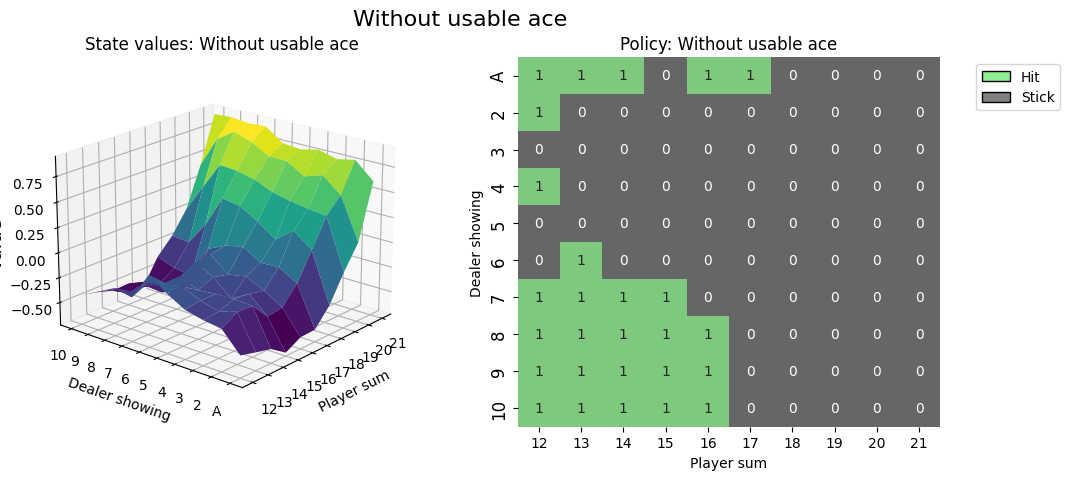

In [ ]:
# state values & policy without usable ace (ace counts as 1)
value_grid, policy_grid = create_grids(agent, usable_ace=False)
fig2 = create_plots(value_grid, policy_grid, title="Without usable ace")
plt.show()

<img src="file://_static/img/tutorials/blackjack_without_usable_ace.png">

It's good practice to call env.close() at the end of your script,
so that any used resources by the environment will be closed.




## Think you can do better?



In [ ]:
# You can visualize the environment using the play function
# and try to win a few games.

Hopefully this Tutorial helped you get a grip of how to interact with
OpenAI-Gym environments and sets you on a journey to solve many more RL
challenges.

It is recommended that you solve this environment by yourself (project
based learning is really effective!). You can apply your favorite
discrete RL algorithm or give Monte Carlo ES a try (covered in [Sutton &
Barto](http://incompleteideas.net/book/the-book-2nd.html), section
5.3) - this way you can compare your results directly to the book.

Best of fun!


